In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_recall_curve, auc
)
from sklearn.preprocessing import LabelEncoder
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import BorderlineSMOTE, SMOTE

# Load datasets
train_no_smote = pd.read_csv('../data/processed/train_set.csv')
test_set = pd.read_csv('../data/processed/test_set.csv')

# Define feature columns
feature_columns = [col for col in test_set.columns if col not in ["credit_status", "id"]]

## Random Forest Base Model
We evaluate the performance of a baseline Random Forest model with No SMOTE, SMOTE, SMOTEENN, and Borderline SMOTE


--- No SMOTE ---
Accuracy: 0.8402358749314317
Confusion Matrix:
[[ 283  358]
 [ 807 5844]]
Classification Report:
              precision    recall  f1-score   support

         Bad       0.26      0.44      0.33       641
        Good       0.94      0.88      0.91      6651

    accuracy                           0.84      7292
   macro avg       0.60      0.66      0.62      7292
weighted avg       0.88      0.84      0.86      7292


--- SMOTE ---
Accuracy: 0.8769884805266045
Confusion Matrix:
[[ 225  416]
 [ 481 6170]]
Classification Report:
              precision    recall  f1-score   support

         Bad       0.32      0.35      0.33       641
        Good       0.94      0.93      0.93      6651

    accuracy                           0.88      7292
   macro avg       0.63      0.64      0.63      7292
weighted avg       0.88      0.88      0.88      7292


--- SMOTEENN ---
Accuracy: 0.8621777290181021
Confusion Matrix:
[[ 173  468]
 [ 537 6114]]
Classification Report:
    

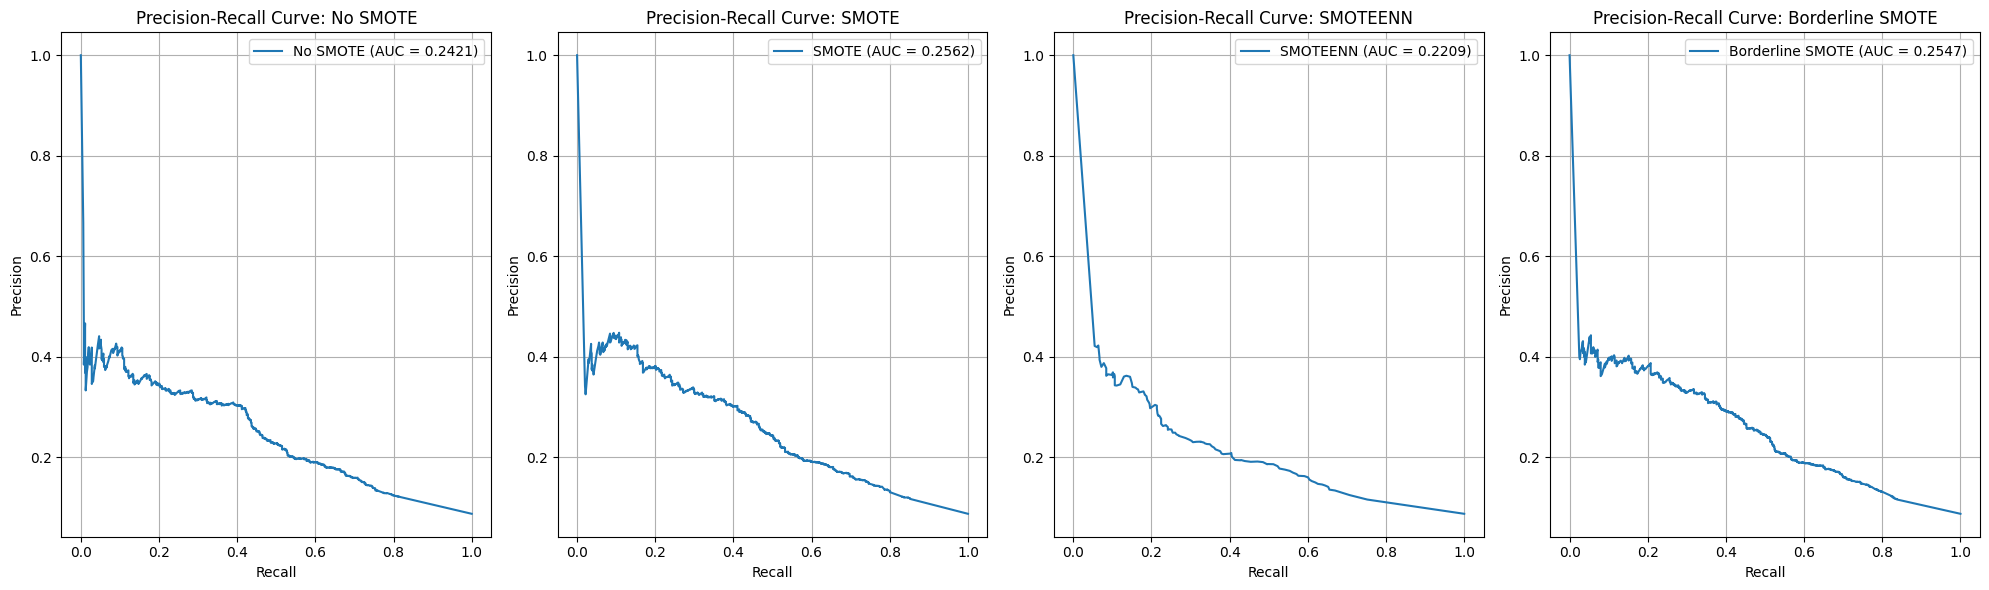

In [5]:
# Function to apply resampling
def apply_resampling(train_df, method):
    X = train_df[feature_columns]
    y = train_df["credit_status"]

    if method == "SMOTE":
        sampler = SMOTE(random_state=42)
    elif method == "SMOTEENN":
        sampler = SMOTEENN(random_state=42)
    elif method == "BorderlineSMOTE":
        sampler = BorderlineSMOTE(random_state=42)
    else:  # No resampling
        return train_df

    X_resampled, y_resampled = sampler.fit_resample(X, y)
    resampled_df = pd.DataFrame(X_resampled, columns=feature_columns)
    resampled_df["credit_status"] = y_resampled
    return resampled_df

# Function to evaluate and collect metrics, PR curve data for different models
def evaluate_and_get_pr_data(train_df, test_df, title="Model"):
    X_train = train_df[feature_columns]
    y_train = train_df["credit_status"]
    X_test = test_df[feature_columns]
    y_test = test_df["credit_status"]

    rf = RandomForestClassifier(random_state=42, class_weight='balanced')
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    # Classification Report and Metrics
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    # Encode for PR Curve
    le = LabelEncoder()
    y_test_encoded = le.fit_transform(y_test)
    bad_index = list(le.classes_).index('Bad')
    y_scores = rf.predict_proba(X_test)[:, bad_index]

    precision, recall, _ = precision_recall_curve(y_test_encoded, y_scores, pos_label=bad_index)
    pr_auc = auc(recall, precision)

    # Return both PR curve data and performance metrics
    return {
        "title": title,
        "precision": precision,
        "recall": recall,
        "pr_auc": pr_auc,
        "accuracy": accuracy,
        "conf_matrix": conf_matrix,
        "class_report": class_report
    }

# Gather PR curve data and metrics for different resampling methods
results = []
results.append(evaluate_and_get_pr_data(train_no_smote, test_set, title="No SMOTE"))
results.append(evaluate_and_get_pr_data(apply_resampling(train_no_smote, "SMOTE"), test_set, title="SMOTE"))
results.append(evaluate_and_get_pr_data(apply_resampling(train_no_smote, "SMOTEENN"), test_set, title="SMOTEENN"))
results.append(evaluate_and_get_pr_data(apply_resampling(train_no_smote, "BorderlineSMOTE"), test_set, title="Borderline SMOTE"))

# Create subplots to display PR curves side by side
fig, axes = plt.subplots(1, 4, figsize=(20, 6))  # 1 row, 4 columns
for i, result in enumerate(results):
    # Display metrics (Accuracy, Confusion Matrix, and Classification Report)
    print(f"\n--- {result['title']} ---")
    print(f"Accuracy: {result['accuracy']}")
    print("Confusion Matrix:")
    print(result['conf_matrix'])
    print("Classification Report:")
    print(result['class_report'])

    # Plot PR Curve
    ax = axes[i]  # Get the subplot axis
    ax.plot(result["recall"], result["precision"], label=f'{result["title"]} (AUC = {result["pr_auc"]:.4f})')
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(f"Precision-Recall Curve: {result['title']}")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()




--- XGBoost (No SMOTE) ---
Accuracy: 0.9094898518924849
Confusion Matrix:
 [[  23  618]
 [  42 6609]]
Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.04      0.07       641
           1       0.91      0.99      0.95      6651

    accuracy                           0.91      7292
   macro avg       0.63      0.51      0.51      7292
weighted avg       0.87      0.91      0.87      7292



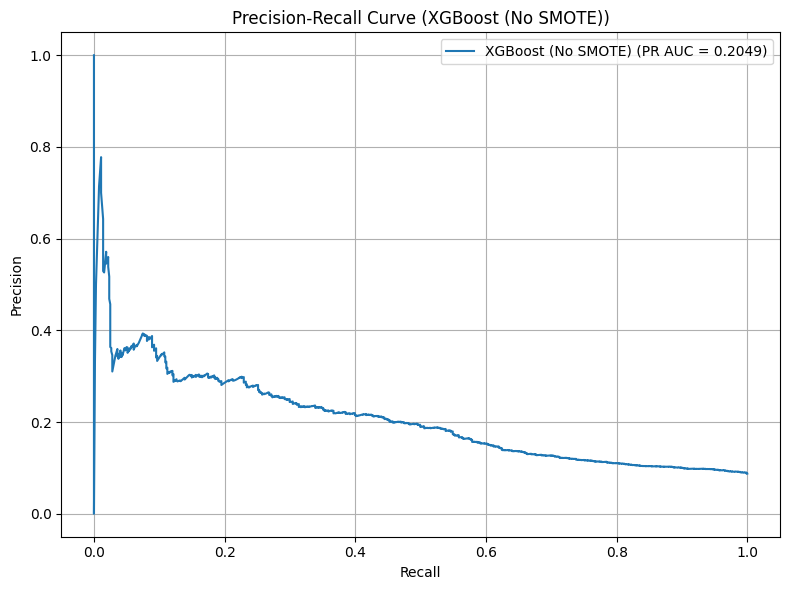


--- XGBoost (SMOTE) ---
Accuracy: 0.8747942951179375
Confusion Matrix:
 [[ 120  521]
 [ 392 6259]]
Classification Report:
               precision    recall  f1-score   support

           0       0.23      0.19      0.21       641
           1       0.92      0.94      0.93      6651

    accuracy                           0.87      7292
   macro avg       0.58      0.56      0.57      7292
weighted avg       0.86      0.87      0.87      7292



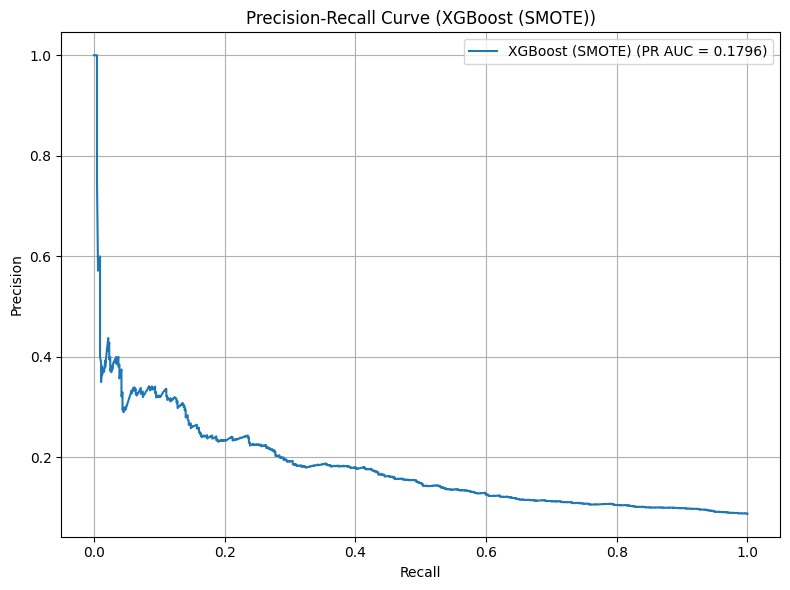


--- XGBoost (SMOTEENN) ---
Accuracy: 0.8956390565002743
Confusion Matrix:
 [[  62  579]
 [ 182 6469]]
Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.10      0.14       641
           1       0.92      0.97      0.94      6651

    accuracy                           0.90      7292
   macro avg       0.59      0.53      0.54      7292
weighted avg       0.86      0.90      0.87      7292



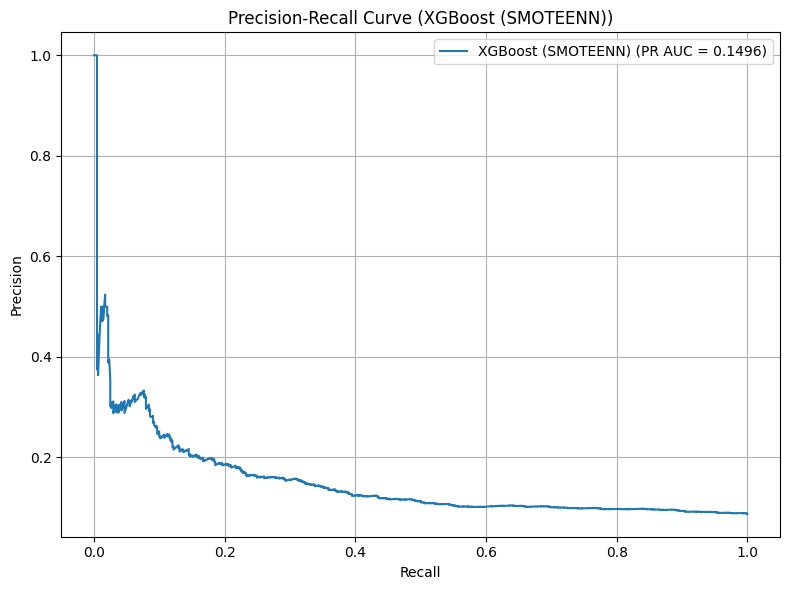


--- XGBoost (Borderline SMOTE) ---
Accuracy: 0.8782227098189797
Confusion Matrix:
 [[ 129  512]
 [ 376 6275]]
Classification Report:
               precision    recall  f1-score   support

           0       0.26      0.20      0.23       641
           1       0.92      0.94      0.93      6651

    accuracy                           0.88      7292
   macro avg       0.59      0.57      0.58      7292
weighted avg       0.87      0.88      0.87      7292



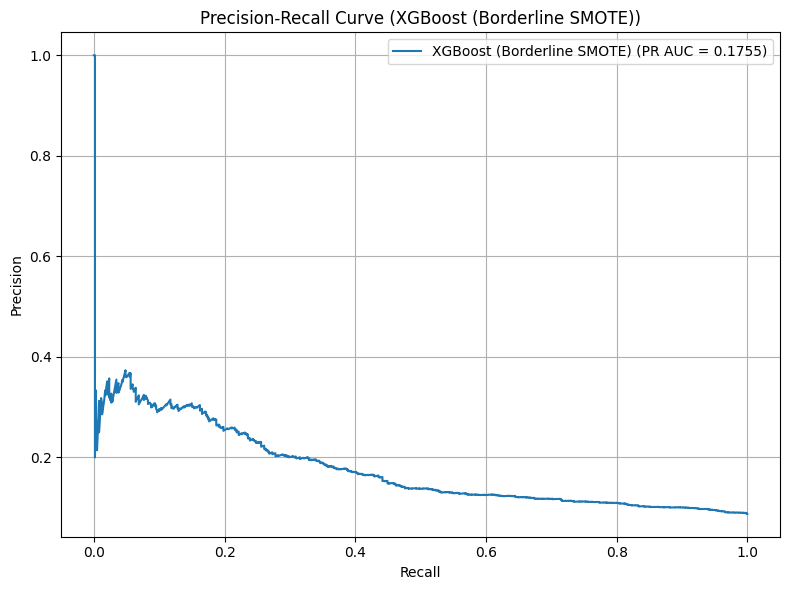

In [53]:
# XGBoost Base Model
# XGBoost with No SMOTE, SMOTE, SMOTEENN, Borderline SMOTE
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_recall_curve, auc
)
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.combine import SMOTEENN

# Load datasets
train_no_smote = pd.read_csv('../data/processed/train_set_noSMOTE.csv')
test_df = pd.read_csv('../data/processed/test_set.csv')

# Define consistent feature columns
feature_columns = [col for col in test_df.columns if col not in ["credit_status", "id"]]

# Apply resampling methods
def apply_resampling(train_df, method):
    X = train_df[feature_columns]
    y = train_df["credit_status"]

    if method == "SMOTE":
        sampler = SMOTE(random_state=42)
    elif method == "SMOTEENN":
        sampler = SMOTEENN(random_state=42)
    elif method == "BorderlineSMOTE":
        sampler = BorderlineSMOTE(random_state=42)
    else:  # No resampling
        return train_df

    X_res, y_res = sampler.fit_resample(X, y)
    resampled_df = pd.DataFrame(X_res, columns=feature_columns)
    resampled_df["credit_status"] = y_res
    return resampled_df

# Evaluation function
def evaluate_xgb_model(train_df, test_df, feature_columns, title="XGBoost Model"):
    le = LabelEncoder()
    y_train = le.fit_transform(train_df["credit_status"])
    y_test = le.transform(test_df["credit_status"])
    bad_index = list(le.classes_).index("Bad")

    X_train = train_df[feature_columns]
    X_test = test_df[feature_columns]

    xgb = XGBClassifier(eval_metric='logloss')
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)

    print(f"\n--- {title} ---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    y_probs = xgb.predict_proba(X_test)[:, bad_index]
    y_test_binary = (y_test == bad_index).astype(int)
    precision, recall, _ = precision_recall_curve(y_test_binary, y_probs)
    prc_auc = auc(recall, precision)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'{title} (PR AUC = {prc_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ({title})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Run all 4 variants
evaluate_xgb_model(train_no_smote, test_df, feature_columns, title="XGBoost (No SMOTE)")

train_smote = apply_resampling(train_no_smote, "SMOTE")
evaluate_xgb_model(train_smote, test_df, feature_columns, title="XGBoost (SMOTE)")

train_smoteenn = apply_resampling(train_no_smote, "SMOTEENN")
evaluate_xgb_model(train_smoteenn, test_df, feature_columns, title="XGBoost (SMOTEENN)")

train_borderline = apply_resampling(train_no_smote, "BorderlineSMOTE")
evaluate_xgb_model(train_borderline, test_df, feature_columns, title="XGBoost (Borderline SMOTE)")

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging wil


--- Stacking (No SMOTE) ---
Accuracy: 0.9118211738891936
Confusion Matrix:
 [[   8  633]
 [  10 6641]]
Classification Report:
               precision    recall  f1-score   support

         Bad       0.44      0.01      0.02       641
        Good       0.91      1.00      0.95      6651

    accuracy                           0.91      7292
   macro avg       0.68      0.51      0.49      7292
weighted avg       0.87      0.91      0.87      7292


📈 PRC AUC (Bad class): 0.2428


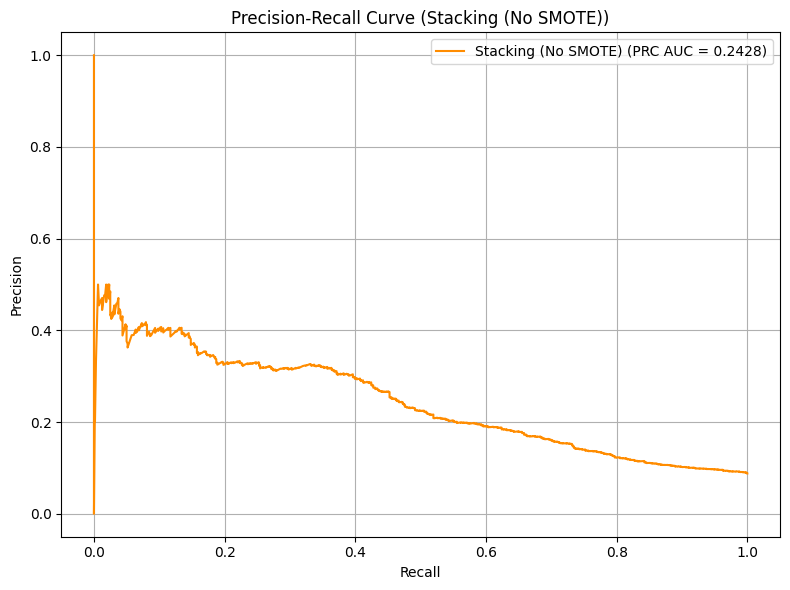


--- Stacking (SMOTE) ---
Accuracy: 0.8813768513439386
Confusion Matrix:
 [[ 199  442]
 [ 423 6228]]
Classification Report:
               precision    recall  f1-score   support

         Bad       0.32      0.31      0.32       641
        Good       0.93      0.94      0.94      6651

    accuracy                           0.88      7292
   macro avg       0.63      0.62      0.63      7292
weighted avg       0.88      0.88      0.88      7292


📈 PRC AUC (Bad class): 0.2437


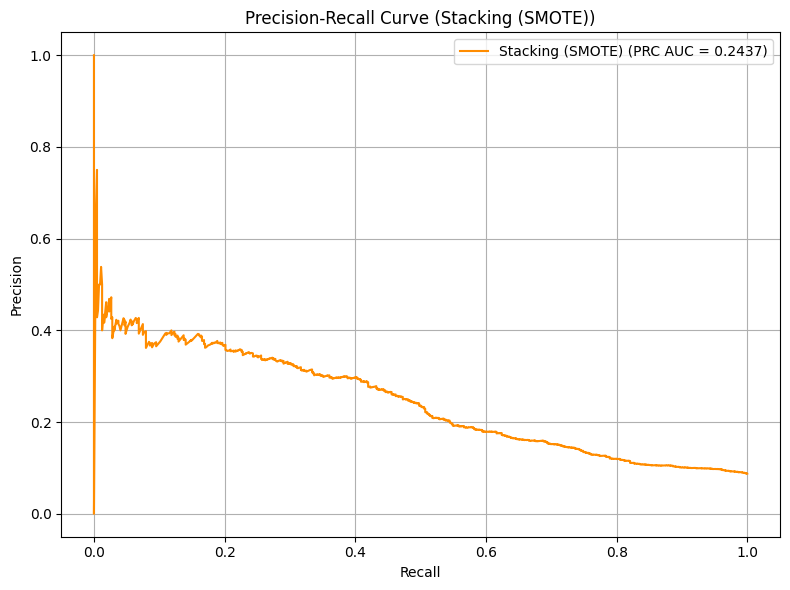

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



--- Stacking (SMOTEENN) ---
Accuracy: 0.8580636313768514
Confusion Matrix:
 [[ 176  465]
 [ 570 6081]]
Classification Report:
               precision    recall  f1-score   support

         Bad       0.24      0.27      0.25       641
        Good       0.93      0.91      0.92      6651

    accuracy                           0.86      7292
   macro avg       0.58      0.59      0.59      7292
weighted avg       0.87      0.86      0.86      7292


📈 PRC AUC (Bad class): 0.2077


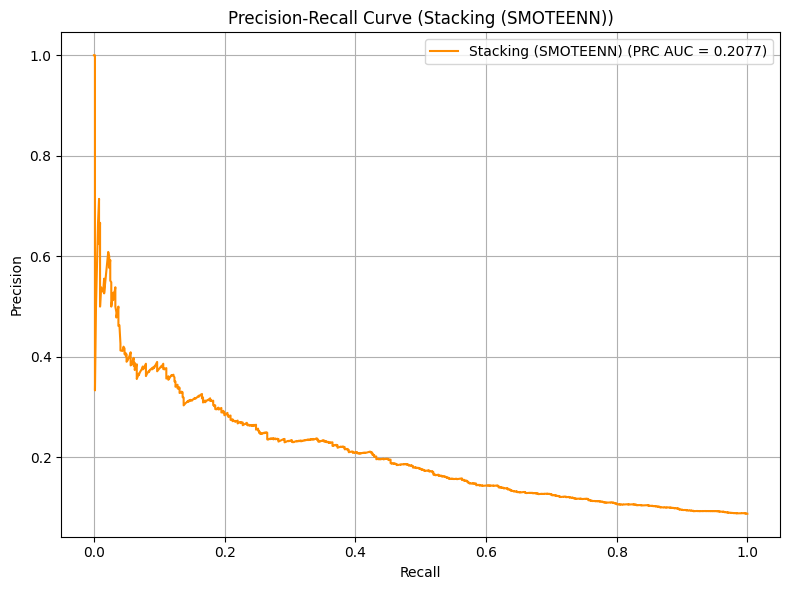

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



--- Stacking (Borderline SMOTE) ---
Accuracy: 0.8811025781678552
Confusion Matrix:
 [[ 202  439]
 [ 428 6223]]
Classification Report:
               precision    recall  f1-score   support

         Bad       0.32      0.32      0.32       641
        Good       0.93      0.94      0.93      6651

    accuracy                           0.88      7292
   macro avg       0.63      0.63      0.63      7292
weighted avg       0.88      0.88      0.88      7292


📈 PRC AUC (Bad class): 0.2434


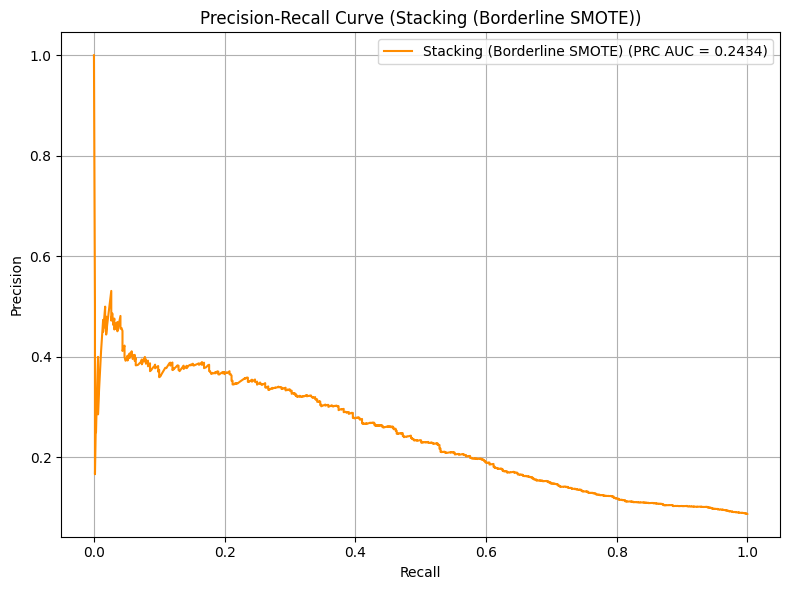

In [54]:
# Stacking Base Model with SMOTE, SMOTEENN, Borderline SMOTE

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_recall_curve, average_precision_score
)
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.combine import SMOTEENN

# Load datasets
train_no_smote = pd.read_csv("../data/processed/train_set_noSMOTE.csv")
test_df = pd.read_csv("../data/processed/test_set.csv")

# Define consistent feature columns
feature_columns = [col for col in test_df.columns if col not in ["credit_status", "id"]]

# Reusable resampling function
def apply_resampling(train_df, method):
    X = train_df[feature_columns]
    y = train_df["credit_status"]

    if method == "SMOTE":
        sampler = SMOTE(random_state=42)
    elif method == "SMOTEENN":
        sampler = SMOTEENN(random_state=42)
    elif method == "BorderlineSMOTE":
        sampler = BorderlineSMOTE(random_state=42)
    else:
        return train_df  # No resampling

    X_res, y_res = sampler.fit_resample(X, y)
    resampled_df = pd.DataFrame(X_res, columns=feature_columns)
    resampled_df["credit_status"] = y_res
    return resampled_df

# Reusable evaluation function
def evaluate_stacking_model(train_df, test_df, feature_columns, title="Stacking Model"):
    # Encode target
    le = LabelEncoder()
    y_train = le.fit_transform(train_df["credit_status"])
    y_test = le.transform(test_df["credit_status"])
    bad_index = list(le.classes_).index("Bad")

    # Feature matrices
    X_train = train_df[feature_columns]
    X_test = test_df[feature_columns]

    # Define base models
    rf = RandomForestClassifier(random_state=42, class_weight='balanced')
    xgb = XGBClassifier(eval_metric='logloss')

    # Define Stacking model
    stacking_model = StackingClassifier(
        estimators=[('rf', rf), ('xgb', xgb)],
        final_estimator=LogisticRegression(max_iter=2000),
        passthrough=True,
        n_jobs=-1
    )

    # Train and predict
    stacking_model.fit(X_train, y_train)
    y_pred = stacking_model.predict(X_test)
    y_probs = stacking_model.predict_proba(X_test)[:, bad_index]

    # Binary indicator for "Bad" class
    y_test_binary = (y_test == bad_index).astype(int)

    # PRC evaluation
    precision, recall, _ = precision_recall_curve(y_test_binary, y_probs)
    prc_auc = average_precision_score(y_test_binary, y_probs)

    # Results
    print(f"\n--- {title} ---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))
    print(f"\n📈 PRC AUC (Bad class): {prc_auc:.4f}")

    # Plot PRC
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'{title} (PRC AUC = {prc_auc:.4f})', color='darkorange')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ({title})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Run all stacking model variants
evaluate_stacking_model(train_no_smote, test_df, feature_columns, title="Stacking (No SMOTE)")

train_smote = apply_resampling(train_no_smote, "SMOTE")
evaluate_stacking_model(train_smote, test_df, feature_columns, title="Stacking (SMOTE)")

train_smoteenn = apply_resampling(train_no_smote, "SMOTEENN")
evaluate_stacking_model(train_smoteenn, test_df, feature_columns, title="Stacking (SMOTEENN)")

train_borderline = apply_resampling(train_no_smote, "BorderlineSMOTE")
evaluate_stacking_model(train_borderline, test_df, feature_columns, title="Stacking (Borderline SMOTE)")


Fitting 3 folds for each of 576 candidates, totalling 1728 fits


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0

[CV] END clf__bootstrap=True, clf__class_weight=None, clf__max_depth=None, clf__max_features=sqrt, clf__max_samples=None, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=100; total time=  10.4s
[CV] END clf__bootstrap=True, clf__class_weight=None, clf__max_depth=None, clf__max_features=sqrt, clf__max_samples=None, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=100; total time=  10.4s
[CV] END clf__bootstrap=True, clf__class_weight=None, clf__max_depth=None, clf__max_features=sqrt, clf__max_samples=None, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time=  10.9s
[CV] END clf__bootstrap=True, clf__class_weight=None, clf__max_depth=None, clf__max_features=sqrt, clf__max_samples=None, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time=  10.6s
[CV] END clf__bootstrap=True, clf__class_weight=None, clf__max_depth=None, clf__max_features=sqrt, clf__max_samples=None, clf__min_samples_l

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
576 fits failed out of a total of 1728.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
576 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  Fi


✅ Best Parameters: {'clf__bootstrap': False, 'clf__class_weight': None, 'clf__max_depth': 10, 'clf__max_features': 'sqrt', 'clf__max_samples': None, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}

🔍 Classification Report (Bad = 1):
              precision    recall  f1-score   support

        Good       0.94      0.66      0.77      6651
         Bad       0.13      0.54      0.21       641

    accuracy                           0.64      7292
   macro avg       0.53      0.60      0.49      7292
weighted avg       0.87      0.64      0.72      7292


🔍 Confusion Matrix:
[[4360 2291]
 [ 298  343]]

📈 PRC AUC: 0.1438


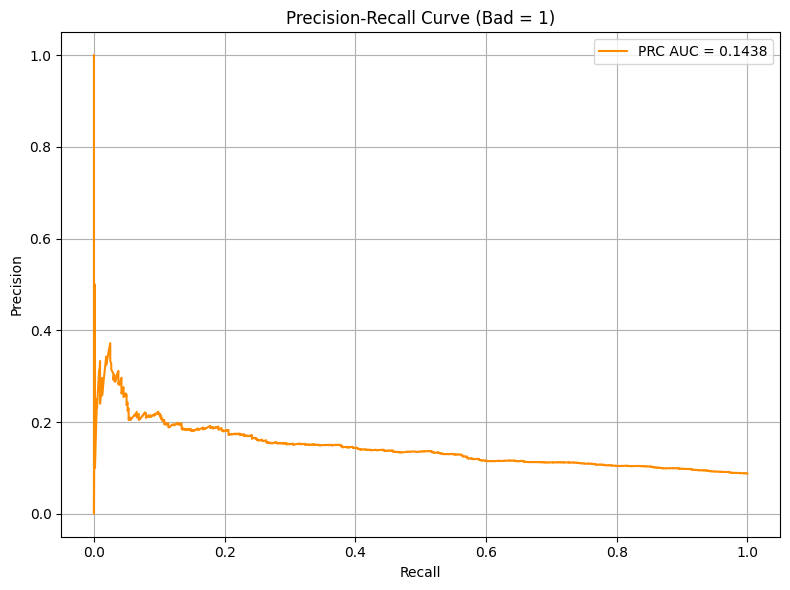


                                          Feature  Importance
0                              log_annual_income    0.226601
1                                            age    0.162454
2                             log_years_employed    0.091106
3                                    family_size    0.069558
4                          family_status_Married    0.044579
5                                     own_realty    0.029662
6                 housing_type_House / apartment    0.029629
7                                        own_car    0.022370
8                                         gender    0.018507
9   education_type_Secondary / secondary special    0.018459
10                                         phone    0.018384
11                           income_type_Working    0.016563
12                                         email    0.016147
13                                    work_phone    0.015660
14               education_type_Higher education    0.015287
15                    

/var/folders/bm/l7y0dmw152vcmvqzjv7gpb6c0000gn/T/ipykernel_68141/3637313107.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature', palette='viridis')


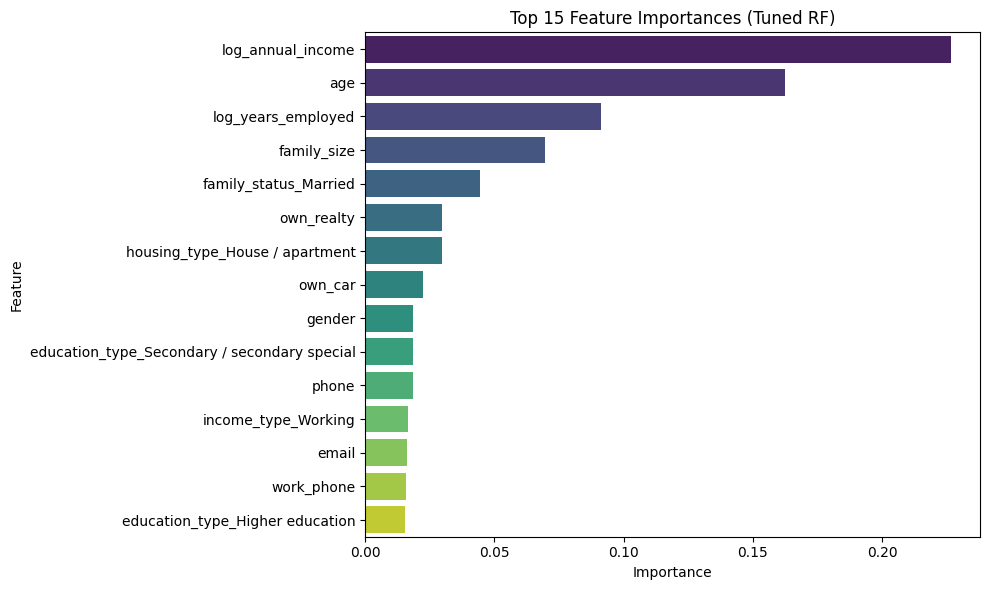

In [ ]:
### Best Random Forest Model seems to be RF + Borderline SMOTE (Balancing PRC AUC, Recall)
### Hyperparameters Tuning RF with Borderline SMOTE to maximise recall
### WARNING: WILL RUN FOR ~ 35 MINUTES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_recall_curve, auc, f1_score, make_scorer
)
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import BorderlineSMOTE

# Load datasets
train_set = pd.read_csv('../data/processed/train_set_noSMOTE.csv')
test_set = pd.read_csv('../data/processed/test_set.csv')

# Use consistent encoding: 'Bad' = 1, 'Good' = 0
y_train = (train_set['credit_status'] == 'Bad').astype(int)
y_test = (test_set['credit_status'] == 'Bad').astype(int)

# Define feature columns
feature_columns = [col for col in test_set.columns if col not in ["credit_status", "id"]]

X_train = train_set[feature_columns]
X_test = test_set[feature_columns]

# Drop known redundant features
redundant_features = ['annual_income', 'years_employed']
X_train_reduced = X_train.drop(columns=redundant_features)
X_test_reduced = X_test.drop(columns=redundant_features)

# Build pipeline
pipeline = ImbPipeline([
    ('smote', BorderlineSMOTE(random_state=42)),
    ('clf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# Define hyperparameter grid
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2],
    'clf__max_features': ['sqrt', 'log2'],
    'clf__bootstrap': [True, False],
    'clf__max_samples': [None, 0.8, 0.6],
    'clf__class_weight': [None, 'balanced']
}

# Use Recall score where 'Bad' is positive class (1)
recall_scorer = make_scorer(recall_score, pos_label=1)

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    scoring=recall_scorer,
    n_jobs=-1,
    verbose=2
)

# Fit model
grid_search.fit(X_train_reduced, y_train)
print("\n✅ Best Parameters:", grid_search.best_params_)

# Use best estimator
pipeline = grid_search.best_estimator_

# Predict with default threshold = 0.5
y_pred = pipeline.predict(X_test_reduced)

# Evaluation
print("\n🔍 Classification Report (Bad = 1):")
print(classification_report(y_test, y_pred, target_names=['Good', 'Bad']))

print("\n🔍 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# PRC AUC
y_proba = pipeline.predict_proba(X_test_reduced)[:, 1]  # prob of class 1 = Bad
precision, recall, _ = precision_recall_curve(y_test, y_proba, pos_label=1)    # Not concerned with thresholds for now, hence throwaway
prc_auc = auc(recall, precision)
print(f"\n📈 PRC AUC: {prc_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PRC AUC = {prc_auc:.4f}', color='darkorange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Bad = 1)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Feature importance
clf = pipeline.named_steps['clf']
feat_importances = pd.Series(clf.feature_importances_, index=X_train_reduced.columns)
feat_imp_df = feat_importances.sort_values(ascending=False).reset_index()
feat_imp_df.columns = ['Feature', 'Importance']
print("\n", feat_imp_df)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Feature Importances (Tuned RF)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


✅ Selected Threshold (Recall ≥ 0.5): 0.506
Precision: 0.137, Recall: 0.516, F1: 0.217

🔍 Classification Report (Threshold Tuned):
              precision    recall  f1-score   support

        Good       0.94      0.69      0.79      6651
         Bad       0.14      0.52      0.22       641

    accuracy                           0.67      7292
   macro avg       0.54      0.60      0.50      7292
weighted avg       0.87      0.67      0.74      7292


🔍 Confusion Matrix:
[[4568 2083]
 [ 310  331]]

✅ Best Threshold: 0.506

📈 PRC AUC: 0.1438


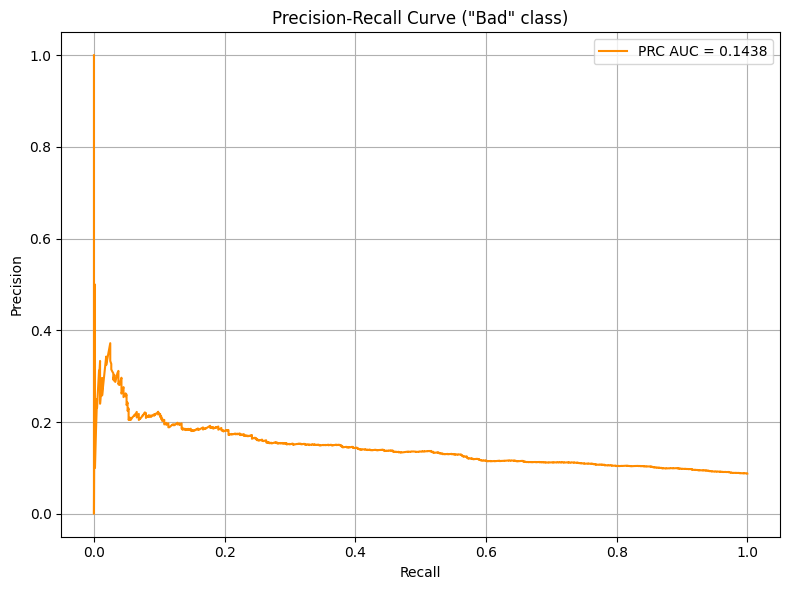


🔍 Top Features:
                                         Feature  Importance
0                              log_annual_income    0.226601
1                                            age    0.162454
2                             log_years_employed    0.091106
3                                    family_size    0.069558
4                          family_status_Married    0.044579
5                                     own_realty    0.029662
6                 housing_type_House / apartment    0.029629
7                                        own_car    0.022370
8                                         gender    0.018507
9   education_type_Secondary / secondary special    0.018459
10                                         phone    0.018384
11                           income_type_Working    0.016563
12                                         email    0.016147
13                                    work_phone    0.015660
14               education_type_Higher education    0.015287


/var/folders/bm/l7y0dmw152vcmvqzjv7gpb6c0000gn/T/ipykernel_68141/2100600642.py:127: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature', palette='viridis')


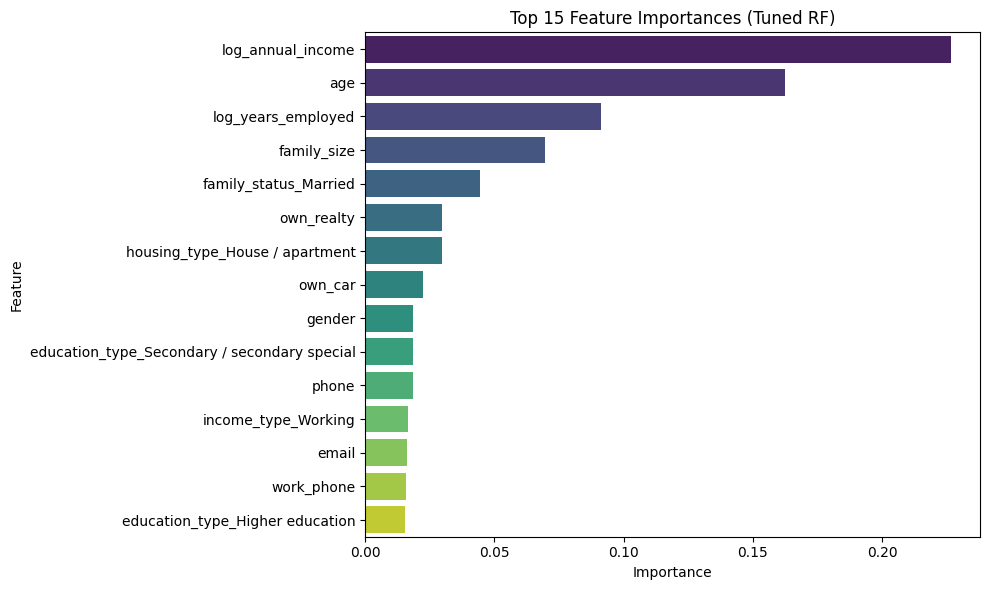

In [ ]:
### Chosen Hyperparameters based on RF + Borderline SMOTE with best RECALL (scoring) rates for "Bad" class
# Further Threshold tuning based on current best hyperparameters, trying to ensure recall for "Bad" class is >= 0.50
# Random Forest + Borderline SMOTE + Hyperparameters tuned + Threshold Tuning


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_recall_curve, auc, f1_score, make_scorer
)
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import BorderlineSMOTE

# Load datasets
train_set = pd.read_csv('../data/processed/train_set_noSMOTE.csv')
test_set = pd.read_csv('../data/processed/test_set.csv')

# Use consistent encoding: 'Bad' = 1, 'Good' = 0
y_train = (train_set['credit_status'] == 'Bad').astype(int)
y_test = (test_set['credit_status'] == 'Bad').astype(int)

# Define feature columns
feature_columns = [col for col in test_set.columns if col not in ["credit_status", "id"]]

X_train = train_set[feature_columns]
X_test = test_set[feature_columns]

# Drop known redundant features
redundant_features = ['annual_income', 'years_employed']
X_train_reduced = X_train.drop(columns=redundant_features)
X_test_reduced = X_test.drop(columns=redundant_features)

# Use best model parameters directly
pipeline = ImbPipeline([
    ('smote', BorderlineSMOTE(random_state=42)),
    ('clf', RandomForestClassifier(
        n_estimators = 100,
        max_depth = 10,
        min_samples_split = 2,
        min_samples_leaf = 2,
        max_features = 'sqrt',
        bootstrap = False,
        max_samples = None,
        class_weight = None,
        random_state = 42
    ))
])

# Fit the best model
pipeline.fit(X_train_reduced, y_train)

# Compute predicted probabilities for class 1 = Bad
y_proba = pipeline.predict_proba(X_test_reduced)[:, 1]

# Use actual test labels (already 1 = Bad, 0 = Good)
y_test_binary = y_test

# Predict probabilities for class 1 ("Bad")
precision, recall, thresholds = precision_recall_curve(y_test_binary, y_proba, pos_label=1)

# ✅ Set recall cutoff for Bad class (class 1)
recall_cutoff = 0.5

# Compute F1 scores
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

# Zip into list of (threshold, precision, recall, f1)
threshold_results = list(zip(thresholds, precision[:-1], recall[:-1], f1_scores[:-1]))

# Filter for thresholds where recall ≥ cutoff
qualified = [res for res in threshold_results if res[2] >= recall_cutoff]

if qualified:
    # Pick threshold with highest F1 score
    best_threshold, best_precision, best_recall, best_f1 = max(qualified, key=lambda x: x[3])
    print(f"\n✅ Selected Threshold (Recall ≥ {recall_cutoff}): {best_threshold:.3f}")
    print(f"Precision: {best_precision:.3f}, Recall: {best_recall:.3f}, F1: {best_f1:.3f}")
else:
    best_threshold = 0.5
    print(f"\n⚠️ No threshold achieves recall ≥ {recall_cutoff}. Using default 0.5.")
    
# Apply chosen threshold
y_pred_custom = (y_proba >= best_threshold).astype(int)

# Evaluation
print("\n🔍 Classification Report (Threshold Tuned):")
print(classification_report(y_test_binary, y_pred_custom, target_names=['Good', 'Bad']))

print("\n🔍 Confusion Matrix:")
print(confusion_matrix(y_test_binary, y_pred_custom))

print(f"\n✅ Best Threshold: {best_threshold:.3f}")

prc_auc = auc(recall, precision)
print(f"\n📈 PRC AUC: {prc_auc:.4f}")


# PRC Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PRC AUC = {prc_auc:.4f}', color='darkorange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve ("Bad" class)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --------------------
# Feature Importance Plot
# --------------------
clf = pipeline.named_steps['clf']
feat_importances = pd.Series(clf.feature_importances_, index=X_train_reduced.columns)
feat_imp_df = feat_importances.sort_values(ascending=False).reset_index()
feat_imp_df.columns = ['Feature', 'Importance']

print("\n🔍 Top Features:")
print(feat_imp_df.head(15))

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Feature Importances (Tuned RF)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

Fitting 3 folds for each of 576 candidates, totalling 1728 fits


Python(73809) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(73810) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(73811) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(73812) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(73813) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(73814) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(73815) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(73816) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pas

[CV] END clf__bootstrap=True, clf__class_weight=None, clf__max_depth=None, clf__max_features=sqrt, clf__max_samples=None, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=100; total time=   9.5s
[CV] END clf__bootstrap=True, clf__class_weight=None, clf__max_depth=None, clf__max_features=sqrt, clf__max_samples=None, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=100; total time=   9.5s
[CV] END clf__bootstrap=True, clf__class_weight=None, clf__max_depth=None, clf__max_features=sqrt, clf__max_samples=None, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time=   9.6s
[CV] END clf__bootstrap=True, clf__class_weight=None, clf__max_depth=None, clf__max_features=sqrt, clf__max_samples=None, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time=   9.6s
[CV] END clf__bootstrap=True, clf__class_weight=None, clf__max_depth=None, clf__max_features=sqrt, clf__max_samples=None, clf__min_samples_l

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
576 fits failed out of a total of 1728.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
576 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  Fi


✅ Best Parameters: {'clf__bootstrap': True, 'clf__class_weight': None, 'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__max_samples': 0.8, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}

🔍 Classification Report (Bad = 1):
              precision    recall  f1-score   support

        Good       0.94      0.92      0.93      6651
         Bad       0.30      0.36      0.32       641

    accuracy                           0.87      7292
   macro avg       0.62      0.64      0.63      7292
weighted avg       0.88      0.87      0.87      7292


🔍 Confusion Matrix:
[[6108  543]
 [ 413  228]]

📈 PRC AUC: 0.2502


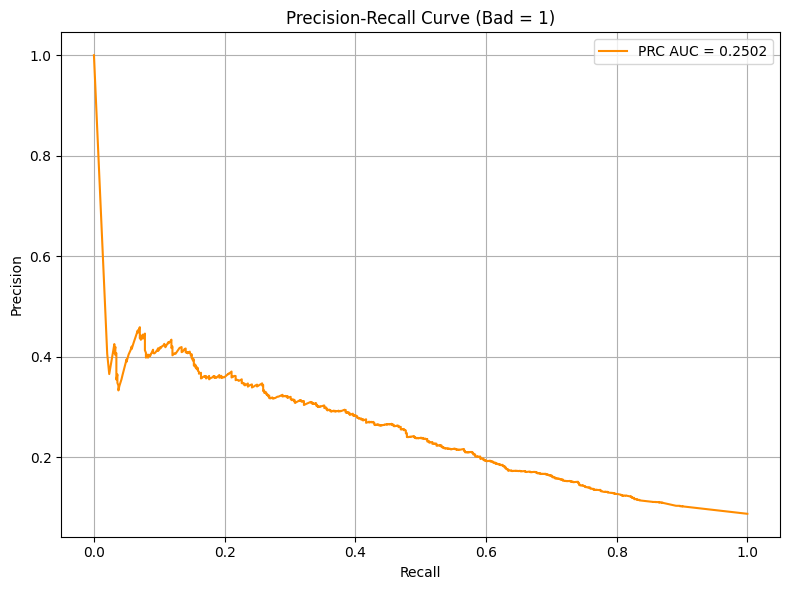


                                          Feature  Importance
0                              log_annual_income    0.218962
1                                            age    0.206955
2                             log_years_employed    0.135818
3                                    family_size    0.055518
4                                        own_car    0.027478
5                                          phone    0.025852
6                                         gender    0.022846
7                                     own_realty    0.020798
8                            income_type_Working    0.019902
9                                     work_phone    0.018942
10                             occupation_Others    0.016578
11  education_type_Secondary / secondary special    0.016289
12                         family_status_Married    0.015487
13               education_type_Higher education    0.015108
14                           occupation_Laborers    0.014388
15                    

/var/folders/bm/l7y0dmw152vcmvqzjv7gpb6c0000gn/T/ipykernel_68141/1390718576.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature', palette='viridis')


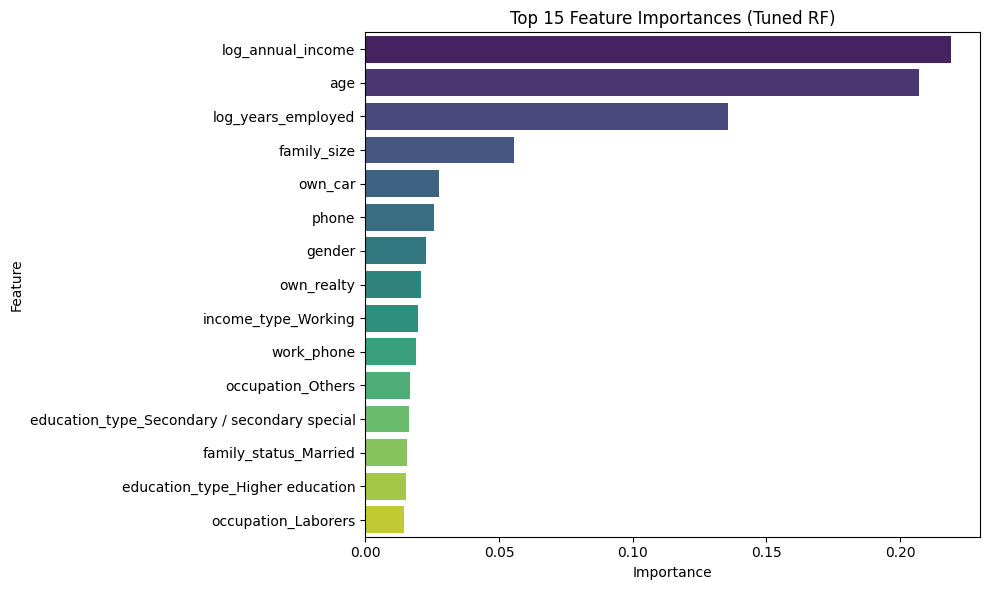

In [77]:
### Best Random Forest Model seems to be RF + Borderline SMOTE (Balancing PRC AUC, Recall)
### Hyperparameters Tuning RF with Borderline SMOTE to maximise f1 score
### WARNING: WILL RUN FOR ~ 35 MINUTES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_recall_curve, auc, f1_score, make_scorer
)
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import BorderlineSMOTE

# Load datasets
train_set = pd.read_csv('../data/processed/train_set_noSMOTE.csv')
test_set = pd.read_csv('../data/processed/test_set.csv')

# Use consistent encoding: 'Bad' = 1, 'Good' = 0
y_train = (train_set['credit_status'] == 'Bad').astype(int)
y_test = (test_set['credit_status'] == 'Bad').astype(int)

# Define feature columns
feature_columns = [col for col in test_set.columns if col not in ["credit_status", "id"]]

X_train = train_set[feature_columns]
X_test = test_set[feature_columns]

# Drop known redundant features
redundant_features = ['annual_income', 'years_employed']
X_train_reduced = X_train.drop(columns=redundant_features)
X_test_reduced = X_test.drop(columns=redundant_features)

# Build pipeline
pipeline = ImbPipeline([
    ('smote', BorderlineSMOTE(random_state=42)),
    ('clf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# Define hyperparameter grid
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2],
    'clf__max_features': ['sqrt', 'log2'],
    'clf__bootstrap': [True, False],
    'clf__max_samples': [None, 0.8, 0.6],
    'clf__class_weight': [None, 'balanced']
}

# Use F1 score where 'Bad' is positive class (1)
f1_scorer = make_scorer(f1_score, pos_label=1)

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    scoring=f1_scorer,
    n_jobs=-1,
    verbose=2
)

# Fit model
grid_search.fit(X_train_reduced, y_train)
print("\n✅ Best Parameters:", grid_search.best_params_)

# Use best estimator
pipeline = grid_search.best_estimator_

# Predict with default threshold = 0.5
y_pred = pipeline.predict(X_test_reduced)

# Evaluation
print("\n🔍 Classification Report (Bad = 1):")
print(classification_report(y_test, y_pred, target_names=['Good', 'Bad']))

print("\n🔍 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# PRC AUC
y_proba = pipeline.predict_proba(X_test_reduced)[:, 1]  # prob of class 1 = Bad
precision, recall, _ = precision_recall_curve(y_test, y_proba, pos_label=1)    # Not concerned with thresholds for now, hence throwaway
prc_auc = auc(recall, precision)
print(f"\n📈 PRC AUC: {prc_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PRC AUC = {prc_auc:.4f}', color='darkorange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Bad = 1)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Feature importance
clf = pipeline.named_steps['clf']
feat_importances = pd.Series(clf.feature_importances_, index=X_train_reduced.columns)
feat_imp_df = feat_importances.sort_values(ascending=False).reset_index()
feat_imp_df.columns = ['Feature', 'Importance']
print("\n", feat_imp_df)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Feature Importances (Tuned RF)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


✅ Selected Threshold (Recall ≥ 0.5): 0.275
Precision: 0.240, Recall: 0.505, F1: 0.325

🔍 Classification Report (Threshold Tuned):
              precision    recall  f1-score   support

        Good       0.95      0.85      0.89      6651
         Bad       0.24      0.51      0.33       641

    accuracy                           0.82      7292
   macro avg       0.59      0.68      0.61      7292
weighted avg       0.88      0.82      0.84      7292


🔍 Confusion Matrix:
[[5625 1026]
 [ 317  324]]

✅ Best Threshold: 0.280

📈 PRC AUC: 0.2502


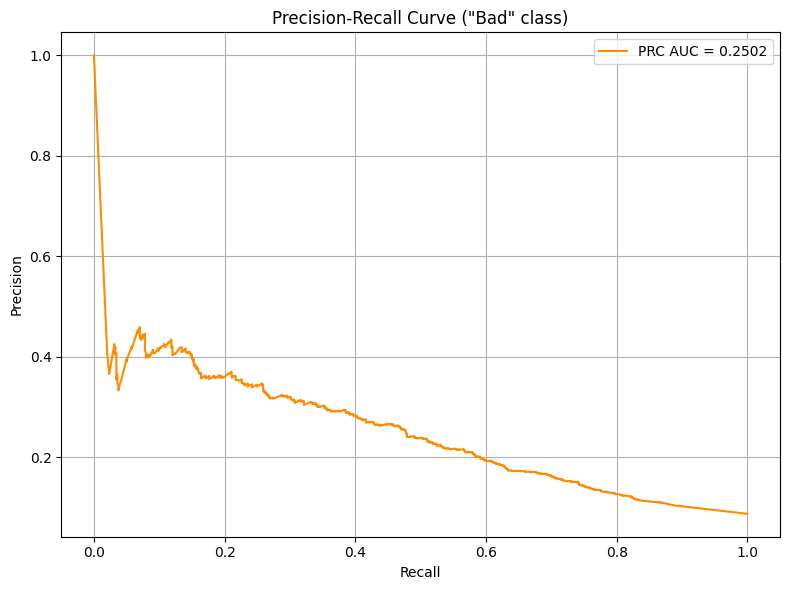


🔍 Top Features:
                                         Feature  Importance
0                              log_annual_income    0.218962
1                                            age    0.206955
2                             log_years_employed    0.135818
3                                    family_size    0.055518
4                                        own_car    0.027478
5                                          phone    0.025852
6                                         gender    0.022846
7                                     own_realty    0.020798
8                            income_type_Working    0.019902
9                                     work_phone    0.018942
10                             occupation_Others    0.016578
11  education_type_Secondary / secondary special    0.016289
12                         family_status_Married    0.015487
13               education_type_Higher education    0.015108
14                           occupation_Laborers    0.014388


/var/folders/bm/l7y0dmw152vcmvqzjv7gpb6c0000gn/T/ipykernel_68141/1344394811.py:126: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature', palette='viridis')


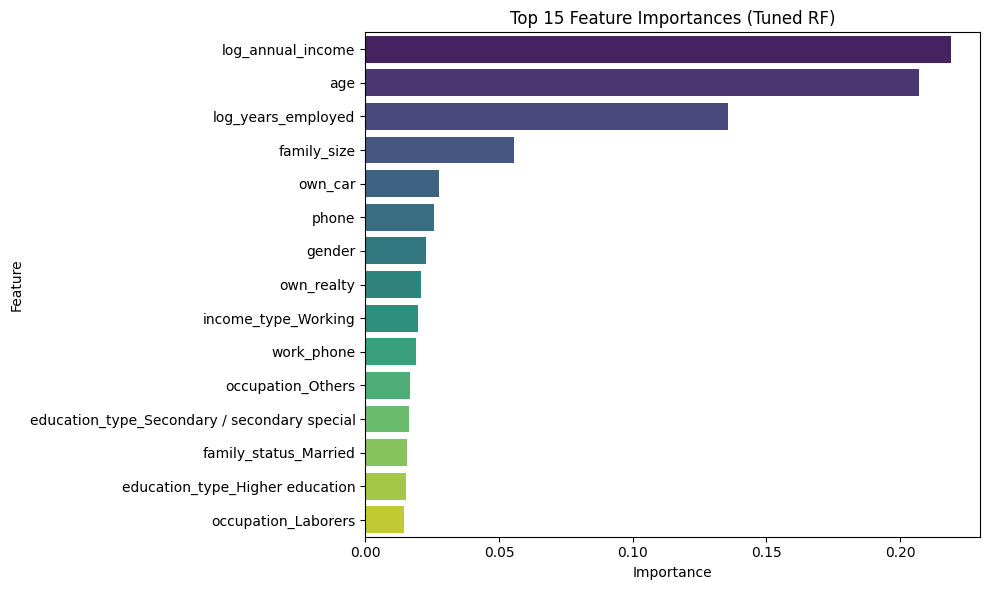

In [7]:
### Chosen Hyperparameters based on RF + Borderline SMOTE with best F1 (scoring) where "Bad" class is positive
# Further Threshold tuning based on current best hyperparameters, trying to ensure recall for "Bad" class is >= 0.50
# Random Forest + Borderline SMOTE + Hyperparameters tuned + Threshold Tuning

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_recall_curve, auc, f1_score, make_scorer
)
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import BorderlineSMOTE

# Load datasets
train_set = pd.read_csv('../data/processed/train_set_noSMOTE.csv')
test_set = pd.read_csv('../data/processed/test_set.csv')

# Use consistent encoding: 'Bad' = 1, 'Good' = 0
y_train = (train_set['credit_status'] == 'Bad').astype(int)
y_test = (test_set['credit_status'] == 'Bad').astype(int)

# Define feature columns
feature_columns = [col for col in test_set.columns if col not in ["credit_status", "id"]]

X_train = train_set[feature_columns]
X_test = test_set[feature_columns]

# Drop known redundant features
redundant_features = ['annual_income', 'years_employed']
X_train_reduced = X_train.drop(columns=redundant_features)
X_test_reduced = X_test.drop(columns=redundant_features)

# Use best model parameters directly
pipeline = ImbPipeline([
    ('smote', BorderlineSMOTE(random_state=42)),
    ('clf', RandomForestClassifier(
        n_estimators = 200,
        max_depth = None,
        min_samples_split = 2,
        min_samples_leaf = 1,
        max_features = 'sqrt',
        bootstrap = True,
        max_samples = 0.8,
        class_weight = None,
        random_state = 42
    ))
])

# Fit the best model
pipeline.fit(X_train_reduced, y_train)

# Compute predicted probabilities for class 1 = Bad
y_proba = pipeline.predict_proba(X_test_reduced)[:, 1]

# Use actual test labels (already 1 = Bad, 0 = Good)
y_test_binary = y_test

# Predict probabilities for class 1 ("Bad")
precision, recall, thresholds = precision_recall_curve(y_test_binary, y_proba, pos_label=1)

# ✅ Set recall cutoff for Bad class (class 1)
recall_cutoff = 0.5

# Compute F1 scores
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

# Zip into list of (threshold, precision, recall, f1)
threshold_results = list(zip(thresholds, precision[:-1], recall[:-1], f1_scores[:-1]))

# Filter for thresholds where recall ≥ cutoff
qualified = [res for res in threshold_results if res[2] >= recall_cutoff]

if qualified:
    # Pick threshold with highest F1 score
    best_threshold, best_precision, best_recall, best_f1 = max(qualified, key=lambda x: x[3])
    print(f"\n✅ Selected Threshold (Recall ≥ {recall_cutoff}): {best_threshold:.3f}")
    print(f"Precision: {best_precision:.3f}, Recall: {best_recall:.3f}, F1: {best_f1:.3f}")
else:
    best_threshold = 0.5
    print(f"\n⚠️ No threshold achieves recall ≥ {recall_cutoff}. Using default 0.5.")
    
# Apply chosen threshold
y_pred_custom = (y_proba >= best_threshold).astype(int)

# Evaluation
print("\n🔍 Classification Report (Threshold Tuned):")
print(classification_report(y_test_binary, y_pred_custom, target_names=['Good', 'Bad']))

print("\n🔍 Confusion Matrix:")
print(confusion_matrix(y_test_binary, y_pred_custom))

print(f"\n✅ Best Threshold: {best_threshold:.3f}")

prc_auc = auc(recall, precision)
print(f"\n📈 PRC AUC: {prc_auc:.4f}")


# PRC Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PRC AUC = {prc_auc:.4f}', color='darkorange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve ("Bad" class)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --------------------
# Feature Importance Plot
# --------------------
clf = pipeline.named_steps['clf']
feat_importances = pd.Series(clf.feature_importances_, index=X_train_reduced.columns)
feat_imp_df = feat_importances.sort_values(ascending=False).reset_index()
feat_imp_df.columns = ['Feature', 'Importance']

print("\n🔍 Top Features:")
print(feat_imp_df.head(15))

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Feature Importances (Tuned RF)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


✅ Selected Threshold (Recall ≥ 0.5): 0.275
Precision: 0.240, Recall: 0.505, F1: 0.325

🔍 Classification Report (Threshold Tuned):
              precision    recall  f1-score   support

        Good       0.95      0.85      0.89      6651
         Bad       0.24      0.51      0.33       641

    accuracy                           0.82      7292
   macro avg       0.59      0.68      0.61      7292
weighted avg       0.88      0.82      0.84      7292


🔍 Confusion Matrix:
[[5625 1026]
 [ 317  324]]

✅ Best Threshold: 0.275

📈 PRC AUC: 0.2492


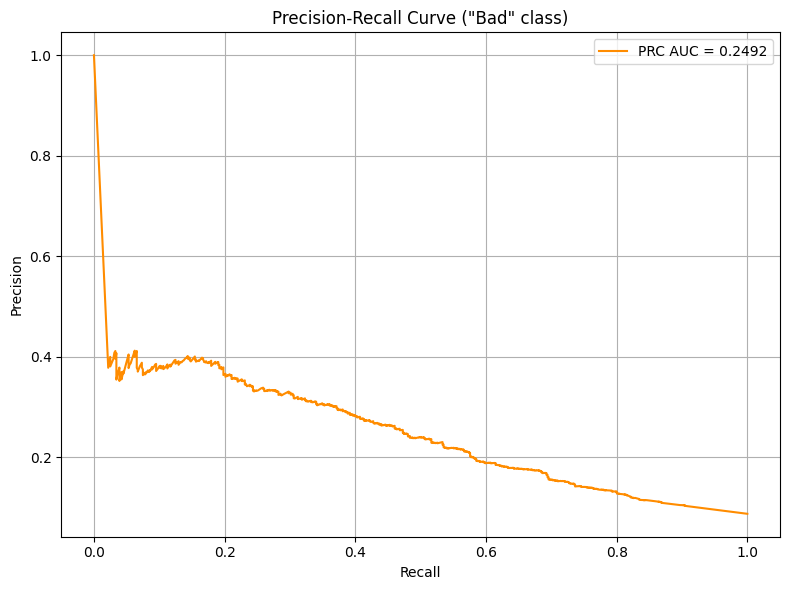


🔍 Top Features:
                                         Feature  Importance
0                              log_annual_income    0.219196
1                                            age    0.205463
2                             log_years_employed    0.136391
3                                    family_size    0.055888
4                                        own_car    0.028670
5                                          phone    0.023868
6                                         gender    0.022395
7                                     own_realty    0.021279
8                            income_type_Working    0.020557
9                                     work_phone    0.018295
10                             occupation_Others    0.016678
11  education_type_Secondary / secondary special    0.016418
12                         family_status_Married    0.015781
13               education_type_Higher education    0.015206
14                           occupation_Laborers    0.013661


C:\Users\sybel\AppData\Local\Temp\ipykernel_10628\92488825.py:133: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature', palette='viridis')


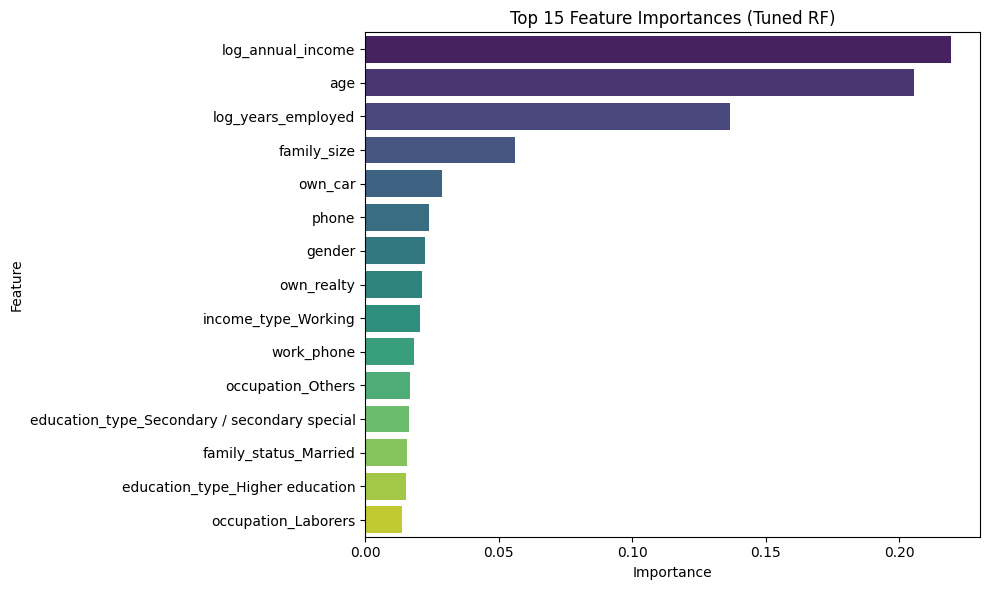

In [ ]:
### Chosen Hyperparameters based on RF + Borderline SMOTE with best F1 (scoring) where "Bad" class is positive
# Further Threshold tuning based on current best hyperparameters, trying to ensure recall for "Bad" class is >= 0.50
# Random Forest + Borderline SMOTE + Hyperparameters tuned + Threshold Tuning

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_recall_curve, auc, f1_score, make_scorer
)
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import BorderlineSMOTE

# Load datasets
train_set = pd.read_csv('../data/processed/train_set_noSMOTE.csv')
test_set = pd.read_csv('../data/processed/test_set.csv')

# Use consistent encoding: 'Bad' = 1, 'Good' = 0
y_train = (train_set['credit_status'] == 'Bad').astype(int)
y_test = (test_set['credit_status'] == 'Bad').astype(int)

# Define feature columns
feature_columns = [col for col in test_set.columns if col not in ["credit_status", "id"]]

X_train = train_set[feature_columns]
X_test = test_set[feature_columns]

# Drop known redundant features
redundant_features = ['annual_income', 'years_employed']
X_train_reduced = X_train.drop(columns=redundant_features)
X_test_reduced = X_test.drop(columns=redundant_features)

# Use best model parameters directly
pipeline = ImbPipeline([
    ('smote', BorderlineSMOTE(random_state=42)),
    ('clf', RandomForestClassifier(
        n_estimators = 200,
        max_depth = None,
        min_samples_split = 2,
        min_samples_leaf = 1,
        max_features = 'sqrt',
        bootstrap = True,
        max_samples = 0.8,
        class_weight = None,
        random_state = 42
    ))
])

# Fit the best model
pipeline.fit(X_train_reduced, y_train)

# Compute predicted probabilities for class 1 = Bad
y_proba = pipeline.predict_proba(X_test_reduced)[:, 1]

# Use actual test labels (already 1 = Bad, 0 = Good)
y_test_binary = y_test

# Predict probabilities for class 1 ("Bad")
precision, recall, thresholds = precision_recall_curve(y_test_binary, y_proba, pos_label=1)

# ✅ Set recall cutoff for Bad class (class 1)
recall_cutoff = 0.5

# Compute F1 scores
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

# Zip into list of (threshold, precision, recall, f1)
threshold_results = list(zip(thresholds, precision[:-1], recall[:-1], f1_scores[:-1]))

# Filter for thresholds where recall ≥ cutoff
qualified = [res for res in threshold_results if res[2] >= recall_cutoff]

if qualified:
    # Pick threshold with highest F1 score
    best_threshold, best_precision, best_recall, best_f1 = max(qualified, key=lambda x: x[3])
    print(f"\n✅ Selected Threshold (Recall ≥ {recall_cutoff}): {best_threshold:.3f}")
    print(f"Precision: {best_precision:.3f}, Recall: {best_recall:.3f}, F1: {best_f1:.3f}")
else:
    best_threshold = 0.5
    print(f"\n⚠️ No threshold achieves recall ≥ {recall_cutoff}. Using default 0.5.")
    
# Apply chosen threshold
y_pred_custom = (y_proba >= best_threshold).astype(int)

############################################################################################## Add predictions to test set##################################################################################
test_set['predicted_credit_status'] = y_pred_custom
test_set['credit_status'] = y_test_binary

############################################################################################# Save the test set with predictions######################################################################################
test_set.to_csv('test_set_with_predictions.csv', index=False)

# Evaluation
print("\n🔍 Classification Report (Threshold Tuned):")
print(classification_report(y_test_binary, y_pred_custom, target_names=['Good', 'Bad']))

print("\n🔍 Confusion Matrix:")
print(confusion_matrix(y_test_binary, y_pred_custom))

print(f"\n✅ Best Threshold: {best_threshold:.3f}")

prc_auc = auc(recall, precision)
print(f"\n📈 PRC AUC: {prc_auc:.4f}")


# PRC Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PRC AUC = {prc_auc:.4f}', color='darkorange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve ("Bad" class)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --------------------
# Feature Importance Plot
# --------------------
clf = pipeline.named_steps['clf']
feat_importances = pd.Series(clf.feature_importances_, index=X_train_reduced.columns)
feat_imp_df = feat_importances.sort_values(ascending=False).reset_index()
feat_imp_df.columns = ['Feature', 'Importance']

print("\n🔍 Top Features:")
print(feat_imp_df.head(15))

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Feature Importances (Tuned RF)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()